In [1]:
import pandas as pd
import numpy as np
import sys
import keras
import sklearn
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, Flatten
from keras.layers import LSTM, SimpleRNN, GRU, Bidirectional, BatchNormalization,Convolution1D,MaxPooling1D, Reshape, GlobalAveragePooling1D
from keras.utils import to_categorical
import sklearn.preprocessing
from sklearn import metrics
from scipy.stats import zscore
from tensorflow.keras.utils import get_file, plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
print(pd.__version__)
print(np.__version__)
print(sys.version)
print(sklearn.__version__)

Using TensorFlow backend.


1.0.3
1.18.1
3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
[GCC 7.3.0]
0.22.2.post1


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kdd-cup-1999-data/kddcup.data_10_percent.gz
/kaggle/input/kdd-cup-1999-data/kddcup.data_10_percent_corrected
/kaggle/input/kdd-cup-1999-data/typo-correction.txt
/kaggle/input/kdd-cup-1999-data/kddcup.testdata.unlabeled.gz
/kaggle/input/kdd-cup-1999-data/corrected.gz
/kaggle/input/kdd-cup-1999-data/training_attack_types
/kaggle/input/kdd-cup-1999-data/kddcup.data.gz
/kaggle/input/kdd-cup-1999-data/kddcup.testdata.unlabeled_10_percent.gz
/kaggle/input/kdd-cup-1999-data/kddcup.names
/kaggle/input/kdd-cup-1999-data/kddcup.newtestdata_10_percent_unlabeled.gz
/kaggle/input/kdd-cup-1999-data/kddcup.data.corrected
/kaggle/input/kdd-cup-1999-data/kddcup.testdata.unlabeled/kddcup.testdata.unlabeled
/kaggle/input/kdd-cup-1999-data/corrected/corrected
/kaggle/input/kdd-cup-1999-data/kddcup.newtestdata_10_percent_unlabeled/kddcup.newtestdata_10_percent_unlabeled
/kaggle/input/kdd-cup-1999-data/kddcup.testdata.unlabeled_10_percent/kddcup.testdata.unlabeled_10_percent
/kaggle/input/kdd-

In [3]:
#Loading training set into dataframe
df = pd.read_csv('../input/unsw-nb15/UNSW_NB15_testing-set.csv')
df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [4]:
#Loading testing set into dataframe
qp = pd.read_csv('../input/unsw-nb15/UNSW_NB15_training-set.csv')
qp.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [5]:
#Dropping the last columns of training set
df = df.drop('id', 1) # we don't need it in this project
df.shape

(175341, 44)

In [6]:
df = df.drop('attack_cat', 1) # we don't need it in this project
df.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,1,0,0,0,1,1,0,0
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,1,2,0,0,0,1,6,0,0
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,1,1,3,0,0,0,2,6,0,0
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,1,1,3,1,1,0,2,1,0,0
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,2,1,40,0,0,0,2,39,0,0


In [7]:
#Dropping the last columns of testing set
qp = qp.drop('id', 1)
qp = qp.drop('attack_cat', 1)
qp.shape

(82332, 43)

In [8]:
df.isnull().values.any()

False

In [9]:
qp.isnull().values.any()

False

In [10]:
#defining col list
cols = ['proto','state','service']
cols

['proto', 'state', 'service']

In [11]:
#One-hot encoding
def one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(each, 1)
    return df


In [12]:
#Merging train and test data
combined_data = pd.concat([df,qp])
combined_data

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,1,0,0,0,1,1,0,0
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,1,2,0,0,0,1,6,0,0
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,1,1,3,0,0,0,2,6,0,0
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,1,1,3,1,1,0,2,1,0,0
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,2,1,40,0,0,0,2,39,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,0.000005,udp,-,INT,2,0,104,0,200000.005100,254,...,1,1,2,0,0,0,2,1,0,0
82328,1.106101,tcp,-,FIN,20,8,18062,354,24.410067,254,...,1,1,1,0,0,0,3,2,0,0
82329,0.000000,arp,-,INT,1,0,46,0,0.000000,0,...,1,1,1,0,0,0,1,1,1,0
82330,0.000000,arp,-,INT,1,0,46,0,0.000000,0,...,1,1,1,0,0,0,1,1,1,0


In [13]:
#Applying one hot encoding to combined data
combined_data = one_hot(combined_data,cols)

In [14]:
combined_data

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,service_ftp,service_ftp-data,service_http,service_irc,service_pop3,service_radius,service_smtp,service_snmp,service_ssh,service_ssl
0,0.121478,6,4,258,172,74.087490,252,254,1.415894e+04,8495.365234,...,0,0,0,0,0,0,0,0,0,0
1,0.649902,14,38,734,42014,78.473372,62,252,8.395112e+03,503571.312500,...,0,0,0,0,0,0,0,0,0,0
2,1.623129,8,16,364,13186,14.170161,62,252,1.572272e+03,60929.230470,...,0,0,0,0,0,0,0,0,0,0
3,1.681642,12,12,628,770,13.677108,62,252,2.740179e+03,3358.622070,...,1,0,0,0,0,0,0,0,0,0
4,0.449454,10,6,534,268,33.373826,254,252,8.561499e+03,3987.059814,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,0.000005,2,0,104,0,200000.005100,254,0,8.320000e+07,0.000000,...,0,0,0,0,0,0,0,0,0,0
82328,1.106101,20,8,18062,354,24.410067,254,252,1.241044e+05,2242.109863,...,0,0,0,0,0,0,0,0,0,0
82329,0.000000,1,0,46,0,0.000000,0,0,0.000000e+00,0.000000,...,0,0,0,0,0,0,0,0,0,0
82330,0.000000,1,0,46,0,0.000000,0,0,0.000000e+00,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [15]:
#Function to min-max normalize
def normalize(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode
    @return a DataFrame with normalized specified features
    """
    result = df.copy() # do not touch the original df
    for feature_name in cols:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        if max_value > min_value:
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [16]:
#Dropping subclass column for training set
tmp = combined_data.pop('label')

In [17]:
#Normalizing training set
new_train_df = normalize(combined_data,combined_data.columns)
new_train_df

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,service_ftp,service_ftp-data,service_http,service_irc,service_pop3,service_radius,service_smtp,service_snmp,service_ssh,service_ssl
0,2.024634e-03,0.000470,0.000363,0.000016,0.000012,0.000074,0.988235,1.000000,2.364553e-06,0.000379,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.083170e-02,0.001221,0.003449,0.000049,0.002866,0.000078,0.243137,0.992126,1.401989e-06,0.022458,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.705215e-02,0.000658,0.001452,0.000024,0.000900,0.000014,0.243137,0.992126,2.625704e-07,0.002717,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.802737e-02,0.001033,0.001089,0.000042,0.000053,0.000014,0.243137,0.992126,4.576117e-07,0.000150,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7.490901e-03,0.000845,0.000545,0.000036,0.000018,0.000033,0.996078,0.992126,1.429776e-06,0.000178,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,8.333335e-08,0.000094,0.000000,0.000006,0.000000,0.200000,0.996078,0.000000,1.389445e-02,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82328,1.843502e-02,0.001785,0.000726,0.001257,0.000024,0.000024,0.996078,0.992126,2.072552e-05,0.000100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82329,0.000000e+00,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82330,0.000000e+00,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
tmp

0        0
1        0
2        0
3        0
4        0
        ..
82327    0
82328    0
82329    0
82330    0
82331    0
Name: label, Length: 257673, dtype: int64

In [19]:
#Appending class column to training set
new_train_df["Class"] = tmp
new_train_df

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,service_ftp-data,service_http,service_irc,service_pop3,service_radius,service_smtp,service_snmp,service_ssh,service_ssl,Class
0,2.024634e-03,0.000470,0.000363,0.000016,0.000012,0.000074,0.988235,1.000000,2.364553e-06,0.000379,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1.083170e-02,0.001221,0.003449,0.000049,0.002866,0.000078,0.243137,0.992126,1.401989e-06,0.022458,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2.705215e-02,0.000658,0.001452,0.000024,0.000900,0.000014,0.243137,0.992126,2.625704e-07,0.002717,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,2.802737e-02,0.001033,0.001089,0.000042,0.000053,0.000014,0.243137,0.992126,4.576117e-07,0.000150,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,7.490901e-03,0.000845,0.000545,0.000036,0.000018,0.000033,0.996078,0.992126,1.429776e-06,0.000178,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,8.333335e-08,0.000094,0.000000,0.000006,0.000000,0.200000,0.996078,0.000000,1.389445e-02,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
82328,1.843502e-02,0.001785,0.000726,0.001257,0.000024,0.000024,0.996078,0.992126,2.072552e-05,0.000100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
82329,0.000000e+00,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
82330,0.000000e+00,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [20]:
new_train_df.isnull().values.any()

False

In [21]:
y_train=new_train_df["Class"]
y_train

0        0
1        0
2        0
3        0
4        0
        ..
82327    0
82328    0
82329    0
82330    0
82331    0
Name: Class, Length: 257673, dtype: int64

In [22]:
y_train.isnull().values.any()

False

In [23]:
combined_data_X = new_train_df.drop('Class', 1)
combined_data_X

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,service_ftp,service_ftp-data,service_http,service_irc,service_pop3,service_radius,service_smtp,service_snmp,service_ssh,service_ssl
0,2.024634e-03,0.000470,0.000363,0.000016,0.000012,0.000074,0.988235,1.000000,2.364553e-06,0.000379,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.083170e-02,0.001221,0.003449,0.000049,0.002866,0.000078,0.243137,0.992126,1.401989e-06,0.022458,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.705215e-02,0.000658,0.001452,0.000024,0.000900,0.000014,0.243137,0.992126,2.625704e-07,0.002717,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.802737e-02,0.001033,0.001089,0.000042,0.000053,0.000014,0.243137,0.992126,4.576117e-07,0.000150,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7.490901e-03,0.000845,0.000545,0.000036,0.000018,0.000033,0.996078,0.992126,1.429776e-06,0.000178,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,8.333335e-08,0.000094,0.000000,0.000006,0.000000,0.200000,0.996078,0.000000,1.389445e-02,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82328,1.843502e-02,0.001785,0.000726,0.001257,0.000024,0.000024,0.996078,0.992126,2.072552e-05,0.000100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82329,0.000000e+00,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82330,0.000000e+00,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
oos_pred = []

In [25]:
from sklearn.model_selection import StratifiedKFold

In [26]:
kfold = StratifiedKFold(n_splits=2,shuffle=True,random_state=42)
kfold.get_n_splits(combined_data_X,y_train)

2

In [27]:
batch_size = 32
model = Sequential()
model.add(Convolution1D(64, kernel_size=196, border_mode="same",activation="relu",input_shape=(196, 1)))
model.add(MaxPooling1D(pool_length=(10)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Reshape((128, 1), input_shape = (128, )))
model.add(MaxPooling1D(pool_length=(5)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(64, kernel_size=196, activation="relu", input_shape=(196, 1), padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=10)`
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=5)`
  


In [28]:
for layer in model.layers:
    print(layer.output_shape)

(None, 196, 64)
(None, 19, 64)
(None, 19, 64)
(None, 128)
(None, 128, 1)
(None, 25, 1)
(None, 25, 1)
(None, 256)
(None, 256)
(None, 1)
(None, 1)


In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 196, 64)           12608     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 19, 64)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 19, 64)            256       
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
reshape_1 (Reshape)          (None, 128, 1)            0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 25, 1)             0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 25, 1)            

In [30]:
for train_index, test_index in kfold.split(combined_data_X,y_train):
    train_X, test_X = combined_data_X.iloc[train_index], combined_data_X.iloc[test_index]
    train_y, test_y = y_train.iloc[train_index], y_train.iloc[test_index]
    
    print("train index:",train_index)
    print("test index:",test_index)
    
    x_columns_train = new_train_df.columns.drop('Class')
    x_train_array = train_X[x_columns_train].values
    x_train_1=np.reshape(x_train_array, (x_train_array.shape[0], x_train_array.shape[1], 1))
      
    x_columns_test = new_train_df.columns.drop('Class')
    x_test_array = test_X[x_columns_test].values
    x_test_2=np.reshape(x_test_array, (x_test_array.shape[0], x_test_array.shape[1], 1))
       
   
    model.fit(x_train_1, train_y,validation_data=(x_test_2,test_y), epochs=15)
    
    pred = model.predict_classes(x_test_2)
    score = metrics.accuracy_score(test_y, pred)
    oos_pred.append(score)
    print("Validation score: {}".format(score))

train index: [     1      4      6 ... 257667 257669 257670]
test index: [     0      2      3 ... 257668 257671 257672]
Train on 128836 samples, validate on 128837 samples
Epoch 1/15
128836/128836 [==============================] - 325s 3ms/step - loss: 0.1791 - accuracy: 0.9074 - val_loss: 0.1593 - val_accuracy: 0.9170
Epoch 2/15
128836/128836 [==============================] - 324s 3ms/step - loss: 0.1541 - accuracy: 0.9196 - val_loss: 0.1635 - val_accuracy: 0.9137
Epoch 3/15
128836/128836 [==============================] - 320s 2ms/step - loss: 0.1479 - accuracy: 0.9252 - val_loss: 0.1417 - val_accuracy: 0.9296
Epoch 4/15
128836/128836 [==============================] - 331s 3ms/step - loss: 0.1424 - accuracy: 0.9289 - val_loss: 0.1397 - val_accuracy: 0.9271
Epoch 5/15
128836/128836 [==============================] - 325s 3ms/step - loss: 0.1400 - accuracy: 0.9297 - val_loss: 0.1419 - val_accuracy: 0.9283
Epoch 6/15
128836/128836 [==============================] - 329s 3ms/step - l

In [34]:
oos_pred

[0.9304081901938108, 0.9350724952652986]

In [35]:
from sklearn.metrics import confusion_matrix

In [36]:
test_y.value_counts()

1    82336
0    46500
Name: Class, dtype: int64

In [41]:
confussion_matrix=confusion_matrix(test_y, pred, labels=[0, 1])

In [42]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

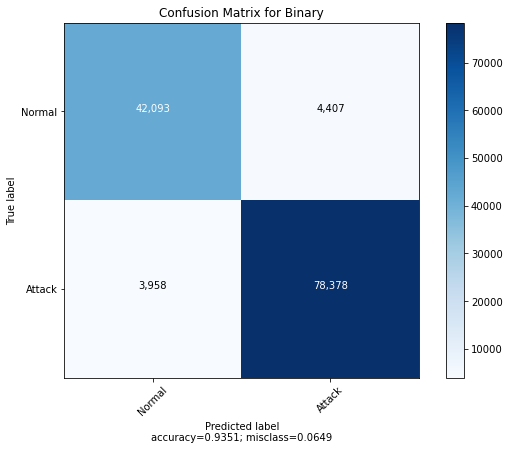

In [43]:
plot_confusion_matrix(cm           = confussion_matrix, 
                      normalize    = False,
                      target_names = ['Normal','Attack'],
                      title        = "Confusion Matrix for Binary")